In [6]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np
import numpy as np
import scipy.optimize

def biasFunc(x, m, c):
    '''Systematic bias of shear estimation
    Parameters:
    ----
    x:  input shear
    m:  multiplicative bias
    c:  additive bias

    Returns:
    ----
    y:  estimated shear
    '''
    y   =   (1+m) * x + c
    return y

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        #data['s2n'] = res['s2n']
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data

In [7]:
def make_data(rng, FbyB, shear, version=0, SbyN=20):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    FbyB: float
        source by background ratio
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear,
        g2=0,
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    
    ngrid = im.array.shape[0]
    flux_tmp = np.sum((im.array)[ngrid//2-2:ngrid//2+3, ngrid//2-2:ngrid//2+3])
    std_tmp =  5
    F = SbyN**2.*(1+FbyB)/FbyB
    B = F/FbyB
    B_val = B/25.0
    F_val=F/25.0
        
    im = (im/flux_tmp)*F
    
    
    if version==0:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val + im.array)/std_tmp
        variance_array = np.ones_like(im.array)*(B_val+im.array)/std_tmp**2
        im += noise_image
            
    if version==1:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val+F_val)/std_tmp
        variance_array = np.ones_like(im.array)*(B_val+F_val)/std_tmp**2
        im += noise_image

        
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    if version==0:
        wt = 1.0/np.average(variance_array)*np.ones_like(variance_array)
    if version==1:
        wt = 1.0/variance_array
        
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [8]:
def analyze(rng, num_tests, num_gals, FbyB, shear_true, version=0, first=False, SbyN=20):
    data = []
    x = []
    y = []
    shear_error = []
    
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        
        for j in range(num_gals):
            imgdata = make_data(rng=rng, FbyB=FbyB, shear=shear_true[i], version=version, SbyN=20)
            obs = imgdata

            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)

        data.append(np.hstack(dlist))

        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02

        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11

        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)

        x.append(FBratioArr[i])
        y.append(shear[0])

            
    return (x, y, shear_error)

In [9]:
rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

In [39]:
FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_tests = len(FBratioArr)
num_gals = 20
g_true= [-0.03, -0.01, 0, 0.01, 0.03]

shear_measurementsSB = []
shear_errorsSB = []

shear_measurementsB = []
shear_errorsB = []

for n in range(num_tests):
    analysis_BandS = analyze(rng, num_tests, num_gals, FBratioArr[n], g_true, version=0, first = True, SbyN=20)
    
    shear_measurementsSB.append(analysis_BandS[1])
    shear_errorsSB.append(analysis_BandS[2])
    
    analysis_Bonly = analyze(rng, num_tests, num_gals, FBratioArr[n], g_true, version=1, first = True, SbyN=20)
    print("FBBratioArr[n] =", FBratioArr[n])
    
    shear_measurementsB.append(analysis_Bonly[1])
    shear_errorsB.append(analysis_Bonly[2])


len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
FBBratioArr[n] = 0.01
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
FBBratioArr[n] = 0.1
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
FBBratioArr[n] = 1.0
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
FBBratioArr[n] = 10.0
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
FBBratioArr[n] = 100.0


In [40]:
print(shear_measurementsSB, "\n")
print(shear_errorsSB, "\n")
print(shear_measurementsB, "\n")
print(shear_errorsB)

[[-0.03852437570769189, -0.010714200322508761, 0.003091917254870124, -0.0016107133631935886, 0.03020705471178848], [-0.03684679022610517, -0.005420396889697888, -0.008594156898294462, 0.009376161630194604, 0.02502770817619574], [-0.03473344680554722, -0.009614745487582812, 0.002604485987315752, 0.007309813557314587, 0.020392434150145054], [-0.03649631682811477, -0.00422008885702749, -0.0005303586241352233, 0.008591134494218862, 0.03417891869149771], [-0.04039157932763009, -0.003718679779062553, 2.161479149632206e-05, 0.011930621393933744, 0.024557000883202985]] 

[[0.007148646864484023, 0.0055017579786781155, 0.0072355478091113146, 0.0051608647478484145, 0.006314155454626991], [0.006873553501001237, 0.006216566572755814, 0.006192064427403103, 0.006291394032889755, 0.0072176042249424], [0.006240793122110361, 0.004167159968816035, 0.005724514591029366, 0.005477860284393955, 0.007131152891859433], [0.004063774058733977, 0.00400707855451153, 0.004310925521652537, 0.004223637734660782, 0.00

In [41]:
#popt, pcov = scipy.optimize.curve_fit(biasFunc, shear_true[0], shear[0], sigma = shear_error[0])

x = np.linspace(-.03*1.5, .03*1.5, len(FBratioArr))

biasListSB = []
errorListSB = []
biasListB = []
errorListB = []

for i in range(len(g_true)):
    print(shear_measurementsSB[i], "\n")
    
print("shape =", np.shape(g_true[0]))

for n in range(len(g_true)):    

    print("g_true[n] =", g_true[n])
    poptSB, pcovSB = scipy.optimize.curve_fit(biasFunc, g_true[n], shear_measurementsSB[n], sigma = shear_errorsSB[n])
    print("shear_measurementsSB[n] = ",shear_measurementsSB[n], "\n")
    print("shear_errorsSB[n] = ",shear_errorsSB[n], "\n")
    print("poptSB = ",poptSB)
    print("pcovSB =", pcovSB, "\n")
    poptB, pcovB = scipy.optimize.curve_fit(biasFunc, g_true[n], shear_measurementsB[n], sigma = shear_errorsB[n])
    print("shear_measurementsB[n] = ",shear_measurementsB[n], "\n")
    print("shear_errorsB[n] = ",shear_errorsB[n], "\n")
    print("poptB = ",poptB)
    print("pcovB =", pcovB, "\n", "\n")
    
    biasListSB.append(poptSB)
    biasListB.append(poptB)
    
    errorListSB.append(pcovSB)
    errorListB.append(pcovB)
    
    del poptSB, pcovSB, poptB, pcovB


print("biasListSB =", biasListSB, "\n")
print("errorListSB =", errorListSB, "\n")
print("biasListB =", biasListB, "\n")
print("errorListB =", errorListB)

[-0.03852437570769189, -0.010714200322508761, 0.003091917254870124, -0.0016107133631935886, 0.03020705471178848] 

[-0.03684679022610517, -0.005420396889697888, -0.008594156898294462, 0.009376161630194604, 0.02502770817619574] 

[-0.03473344680554722, -0.009614745487582812, 0.002604485987315752, 0.007309813557314587, 0.020392434150145054] 

[-0.03649631682811477, -0.00422008885702749, -0.0005303586241352233, 0.008591134494218862, 0.03417891869149771] 

[-0.04039157932763009, -0.003718679779062553, 2.161479149632206e-05, 0.011930621393933744, 0.024557000883202985] 

shape = ()
g_true[n] = -0.03
shear_measurementsSB[n] =  [-0.03852437570769189, -0.010714200322508761, 0.003091917254870124, -0.0016107133631935886, 0.03020705471178848] 

shear_errorsSB[n] =  [0.007148646864484023, 0.0055017579786781155, 0.0072355478091113146, 0.0051608647478484145, 0.006314155454626991] 

poptSB =  [-7057.64377559  -211.70193074]
pcovSB = [[-4.98954460e+15 -1.49686338e+14]
 [-1.49686338e+14 -4.49059011e+12]

[array([-7057.64377559,  -211.70193074]), array([20297.32074756,   202.97957563]), array([ 1.        , -0.00432574]), array([7021.72780025,  -70.22847429]), array([11774.11035599,  -353.25548288])]
[array([-16490.17004646,   -494.67866171]), array([-49451.01408553,   -494.49921023]), array([1.        , 0.00306021]), array([6575.99713103,  -65.76420533]), array([-2374.88290238,    71.21643529])]


/var/folders/h5/jykjt8tx0wd8yrb443l2ssj00000gn/T/ipykernel_13739/2531424656.py:6: RuntimeWarning: invalid value encountered in sqrt
  plot1 = p1.errorbar(np.array(FBratioArr)*1.1, biasListSB[0], np.sqrt(np.diag(errorListSB[0])), fmt='o', label='Background + Source')


ValueError: 'x' and 'y' must have the same size

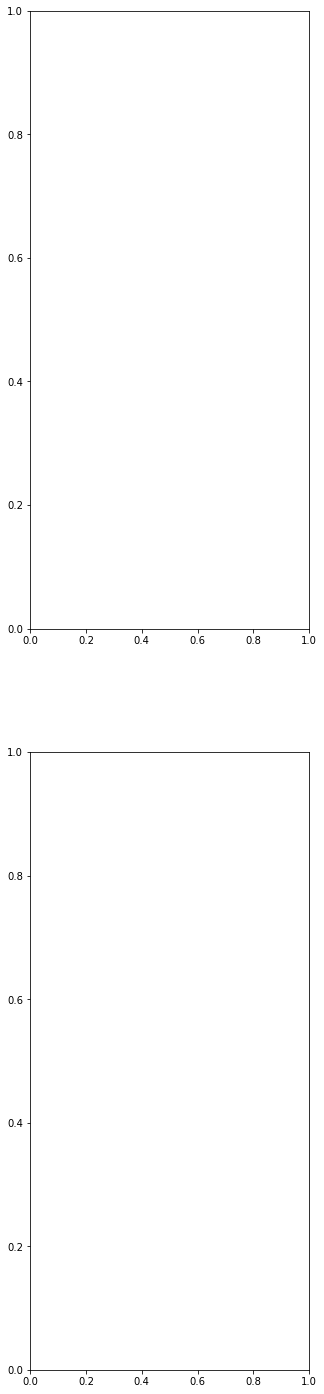

In [47]:
fig, (p1, p2) = plt.subplots(2, figsize=(5,25))

print(biasListSB)
print(biasListB)

plot1 = p1.errorbar(np.array(FBratioArr)*1.1, biasListSB[0], np.sqrt(np.diag(errorListSB[0])), fmt='o', label='Background + Source')
p1.errorbar(FBratioArr, biasListB[0], np.sqrt(np.diag(errorListB[0])), fmt='o', label='Background only')
p1.set_title("Multiplicative Bias Plot")
p1.axhline(0, color="purple")
p1.xlabel(r'$\frac{F}{B}$', fontsize=16)
p1.ylabel(r'$m$', fontsize=16)
p1.xscale("log")


plot2 = p2.errorbar(np.array(FbyBlist)*1.1, biasListSB[1], np.sqrt(np.diag(errorListSB[0])), fmt='o', label='Background + Source')
p2.errorbar(FbyBlist, biasListB[1], np.sqrt(np.diag(errorListB[0])), fmt = 'o', label ='Background only')
p2.axhline(0, color="purple")
p2.xlabel(r'$\frac{F}{B}$', fontsize=16)
p2.ylabel(r'$c$', fontsize=16)
p2.xscale("log")
p2.set_title("Additive Bias Plot")

plt.legend()
plt.show()